In [1]:
import json
import requests
import ast
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import glob
import tensorflow
import crepe
import time
from matplotlib import cm

In [2]:
def get_response(wav_student_path, wav_teacher_path, transcription, metadata):
    """ we send wav file and transcription to the new API """
    # server URL to send request to
    azure_url = "https://smc-gpu1.d2.comp.nus.edu.sg/azure"

    with open(wav_student_path, "rb") as f:
        wav_student = f.read()

    with open(wav_teacher_path, "rb") as f:
        wav_teacher = f.read()

    # prepare for POST request
    payload_azure = {"transcription": transcription, "precalc": False, "metadata": metadata, "shortest_slice": "6"}
    #file_azure = {"wav_teacher": wav_teacher, "wav_student": wav_student, "precalc_teacher": None}
    file_azure = {"wav_teacher": wav_teacher, "wav_student": wav_student, "precalc_teacher": None}

    # send a POST request to the Tornado web server with the file data
    response_azure = requests.post(azure_url, files=file_azure, data=payload_azure)
    return response_azure

In [3]:
# visualise returns from full model

def visualise_results(wav_student_path, raw_return, time_taken, display = True):
    y, sr = librosa.load(wav_student_path)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    returns = ast.literal_eval(raw_return)

    fig, ax = plt.subplots(figsize = [30,10])
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax, cmap = 'Greys_r')
    
    # graph plotting
    student_ts = []
    student_fs = []
    student_confs = []
    student_word_indexes = []
    teacher_ts = []
    teacher_fs = []
    teacher_confs = []
    teacher_word_indexes = []

    # word outcomes
    correct_phones = []
    sounds_likes = []
    phone_scores = []
    tone_scores = []
    suggestions = []
    student_alignments = []
    teacher_alignments = []
    word_indices = []

    # parse
    word_index = 0
    for word_data in returns[1]:
        if word_index != word_data[1]:
            print('index parse error')
            print(word_index, word_data[1])
        word_indices.append(word_index)
        student_alignment = word_data[2]
        teacher_alignment = word_data[3]
        student_alignments.append(student_alignment)
        teacher_alignments.append(teacher_alignment)
        phone_scores.append(word_data[4][0])
        sounds_likes.append(word_data[4][1])
        correct_phones.append(word_data[4][2])
        tone_scores.append(max(0, 100 - 10*word_data[5][0]))

        student_t = word_data[5][1][0]
        student_f = word_data[5][1][1]
        student_conf = word_data[5][1][2]
        
        teacher_t = word_data[5][2][0]
        teacher_f = word_data[5][2][1]
        teacher_conf = word_data[5][2][2]

        suggestions.append(word_data[5][3])
        print(word_index,"- canonical:", word_data[4][2],", MDD:", word_data[4][1],", tone recommendations:", word_data[5][3])

        # we rescale it to match the student graph
        if len(student_t) > 0:
            actual_student_range = max(student_t) - min(student_t)

            for t1,f1,c1 in zip(student_t, student_f, student_conf):
                student_ts.append(student_alignment[0] + t1 * (student_alignment[1] - student_alignment[0])/actual_student_range)
                student_fs.append(f1)
                student_confs.append(c1)
                student_word_indexes.append(word_index)
        
        if len(teacher_t) > 0:
            actual_teacher_range = max(teacher_t) - min(teacher_t)

            for t2,f2,c2 in zip(teacher_t, teacher_f, teacher_conf):
                teacher_ts.append(student_alignment[0] + t2 * (student_alignment[1] - student_alignment[0])/actual_teacher_range)
                teacher_fs.append(f2)
                teacher_confs.append(c2)
                teacher_word_indexes.append(word_index)
        
        word_index += 1

    student_f0_curve = pd.DataFrame([student_ts, student_fs, student_confs, student_word_indexes], index = ['t', 'f0', 'conf', 'word']).transpose()
    teacher_f0_curve = pd.DataFrame([teacher_ts, teacher_fs, teacher_confs, teacher_word_indexes], index = ['t', 'f0', 'conf', 'word']).transpose()

    # plot alignments
    for character_index in word_indices:
        onset_time = student_alignments[character_index][0]
        offset_time = student_alignments[character_index][1]
        transcription = correct_phones[character_index]
        sounds_like = sounds_likes[character_index]
        phone_score = phone_scores[character_index]
        tone_score = tone_scores[character_index]

        student_data = student_f0_curve.loc[student_f0_curve['word'] == character_index]
        teacher_data = teacher_f0_curve.loc[teacher_f0_curve['word'] == character_index]

        all_freqs = list(student_data['f0'])
        for x in teacher_data['f0']:
            all_freqs.append(x)
        y = max(100,np.percentile(all_freqs, 0))/2
        cm_value = cm.bwr_r(phone_score/100)
        ax.scatter([onset_time, offset_time], [y,y], color = cm_value, marker="|", s = 300)
        ax.plot([onset_time, offset_time], [y,y], color = cm_value)
        ax.axvline(onset_time, color = cm_value, alpha = 0.8, linewidth = 0.5)
        ax.axvline(offset_time, color = cm_value, alpha = 0.8, linewidth = 0.5)
        ax.text(x = (onset_time+offset_time)/2, y = y*1.20, s = transcription, color = cm_value, ha = 'center', va = 'bottom', size = 8)
        ax.text(x = (onset_time+offset_time)/2, y = y*1.05, s = sounds_like, color = cm_value, ha = 'center', va = 'bottom', size = 8)
        ax.text(x = (onset_time+offset_time)/2, y = y*0.95, s = phone_score, color = cm_value, ha = 'center', va = 'top', size = 12)
        ax.text(x = (onset_time+offset_time)/2, y = y*0.70, s = int(tone_score), color = 'red', ha = 'center', va = 'top', size = 16)

    # plot points
    for title, colour, f0_curve in zip(['teacher','student'], ['lime','red'], [teacher_f0_curve, student_f0_curve]):
        #ax.scatter(f0_curve['t'], f0_curve['f0'], color = colour, marker = 'X', s = 15, label = 'ignored points')
        ax.scatter(f0_curve['t'], f0_curve['f0'], alpha = [min(1, x*3) for x in f0_curve['conf']], color = colour, marker = 'X', s = 25)
        ax.scatter([np.NaN], [np.NaN], color = colour, marker = 'X', s = 25, label = title)

    ax.set_ylim([0,1024])
    ax.legend(loc="upper right")

    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.set(title = wav_student_path.split('/')[-1].split('//')[-1]+", time taken: "+str(np.round(time_taken,2))+"s")
    plt.savefig('./test_results/spectrogram_'+wav_student_path.split('/')[-1].split('\\')[-1].split('.')[0])

    

    if display:
        plt.show()
        plt.close()
    else:
        plt.close()
    
    

#time_taken = 0
#visualise_results(wav_student_path, response_azure.text, time_taken, display = True)


./test_audio/poem1_teacher.wav
--------------------------------
poem1_jonathan(errors).wav
time 17.751363277435303
0 - canonical: e 2 , MDD: ee er4 , tone recommendations: This word should have a rising tone, but you spoke it with a falling tone.
1 - canonical: e 2 , MDD: ee er4 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: e 2 , MDD: ee er4 , tone recommendations: This word should have a rising tone, but you spoke it with a falling tone.
3 - canonical: qu 1 , MDD: q i1 , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
4 - canonical: xiang 4 , MDD: correct , tone recommendations: Your tone shape is correct
5 - canonical: xiang 4 , MDD: correct , tone recommendations: Your tone shape is correct
6 - canonical: tian 1 , MDD: correct , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
7 - canonical: ge 1 , MDD: g e1 , tone recommendati

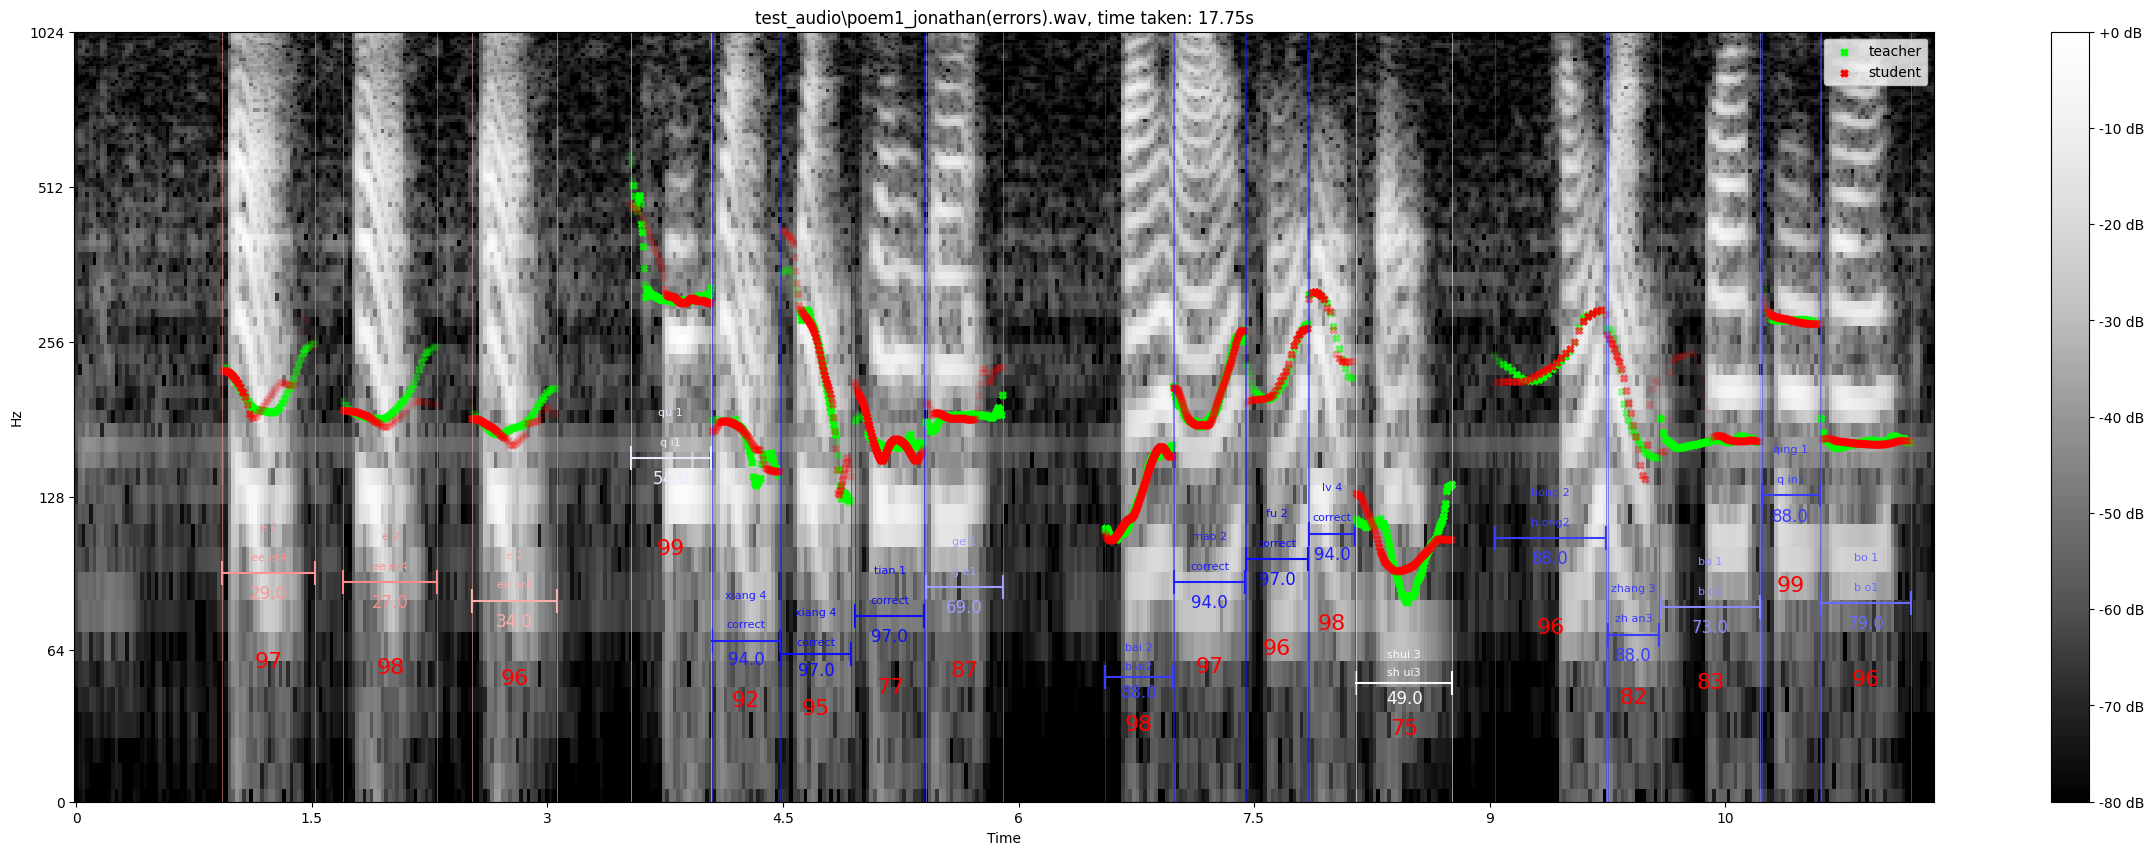

./test_audio/poem1_teacher.wav
--------------------------------
poem1_jonathan.wav
time 18.445557355880737
0 - canonical: e 2 , MDD: ee e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
1 - canonical: e 2 , MDD: ee e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: e 2 , MDD: ee er2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
3 - canonical: qu 1 , MDD: correct , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
4 - canonical: xiang 4 , MDD: correct , tone recommendations: Your tone shape is correct
5 - canonical: xiang 4 , MDD: correct , tone recommendations: This word should have a falling tone, but you spoke it with a flat tone.
6 - canonical: tian 1 , MDD: correct , tone recommendations: Your tone shape is correct
7 - canonical: ge 1 , MDD: g e1 , tone recommendations: Your ton

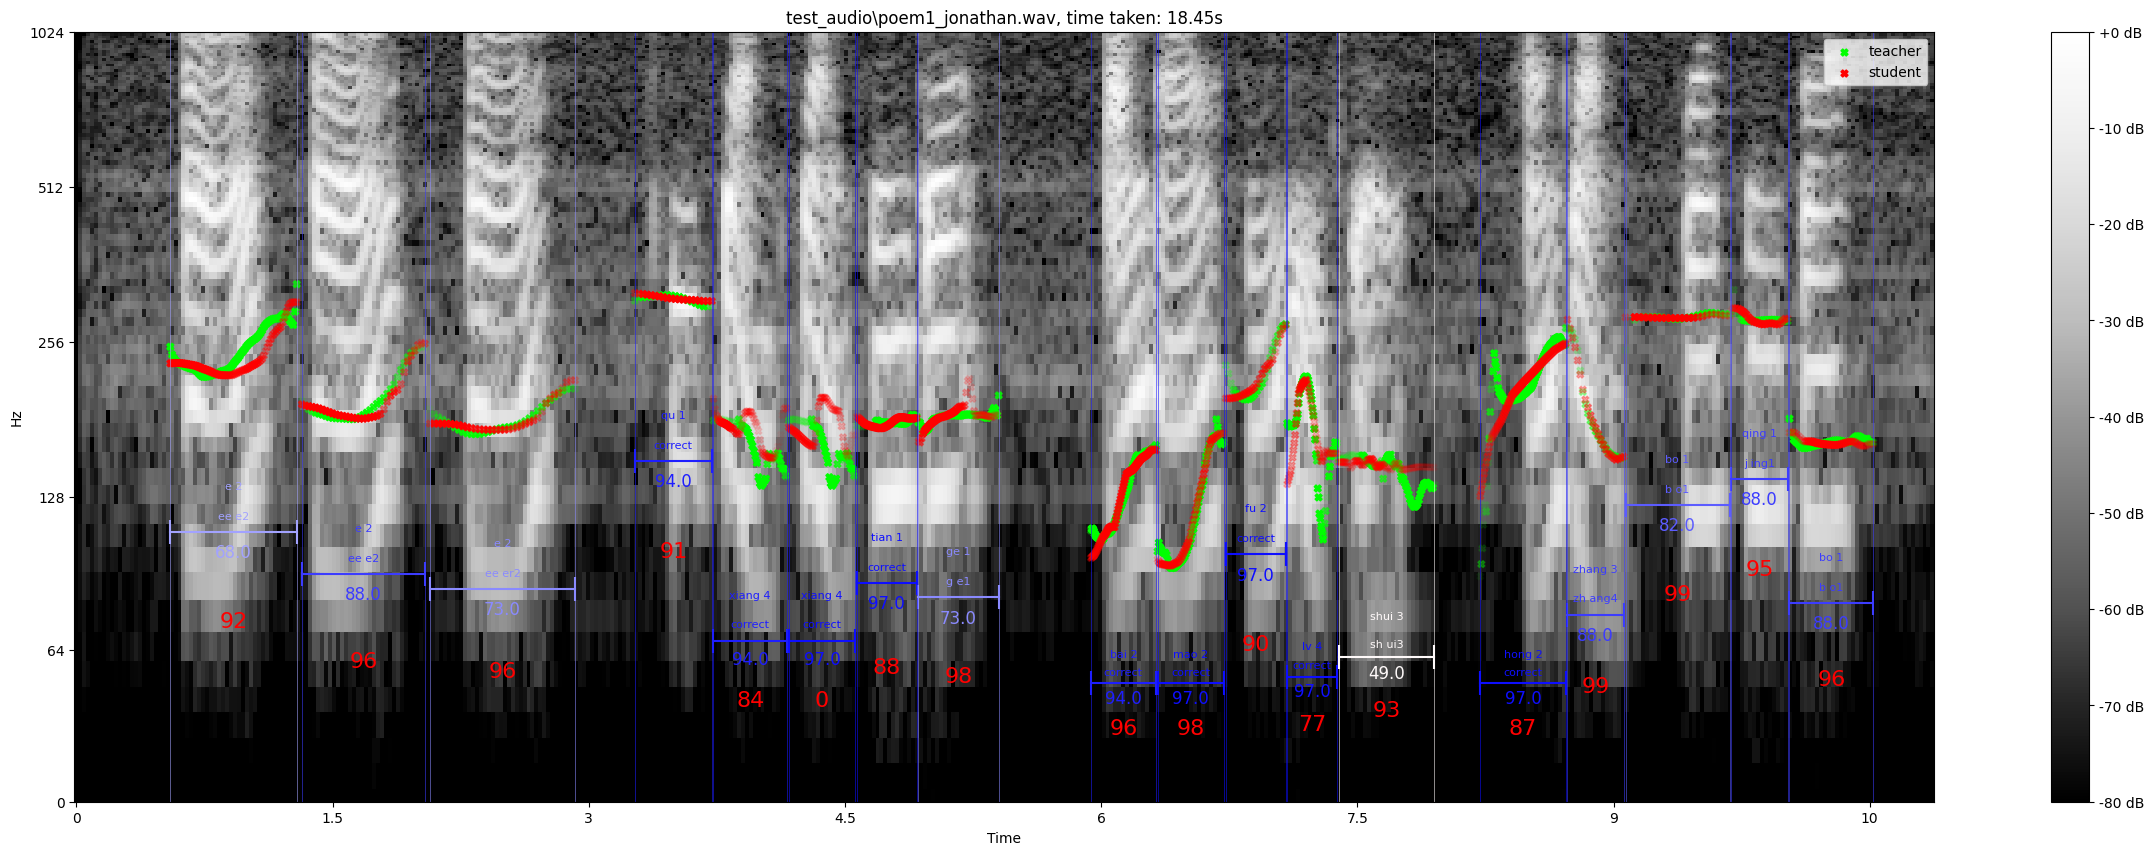

./test_audio/poem1_teacher.wav
--------------------------------
poem1_other-AI.wav
time 17.185957670211792
0 - canonical: e 2 , MDD: ee er3 , tone recommendations: This word should have a rising tone, but you spoke it with a falling tone.
1 - canonical: e 2 , MDD: ee er3 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: e 2 , MDD: ee er2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
3 - canonical: qu 1 , MDD: q v1 , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
4 - canonical: xiang 4 , MDD: correct , tone recommendations: Your tone shape is correct
5 - canonical: xiang 4 , MDD: correct , tone recommendations: Your tone shape is correct
6 - canonical: tian 1 , MDD: correct , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
7 - canonical: ge 1 , MDD: g e1 , tone recommendations: Your t

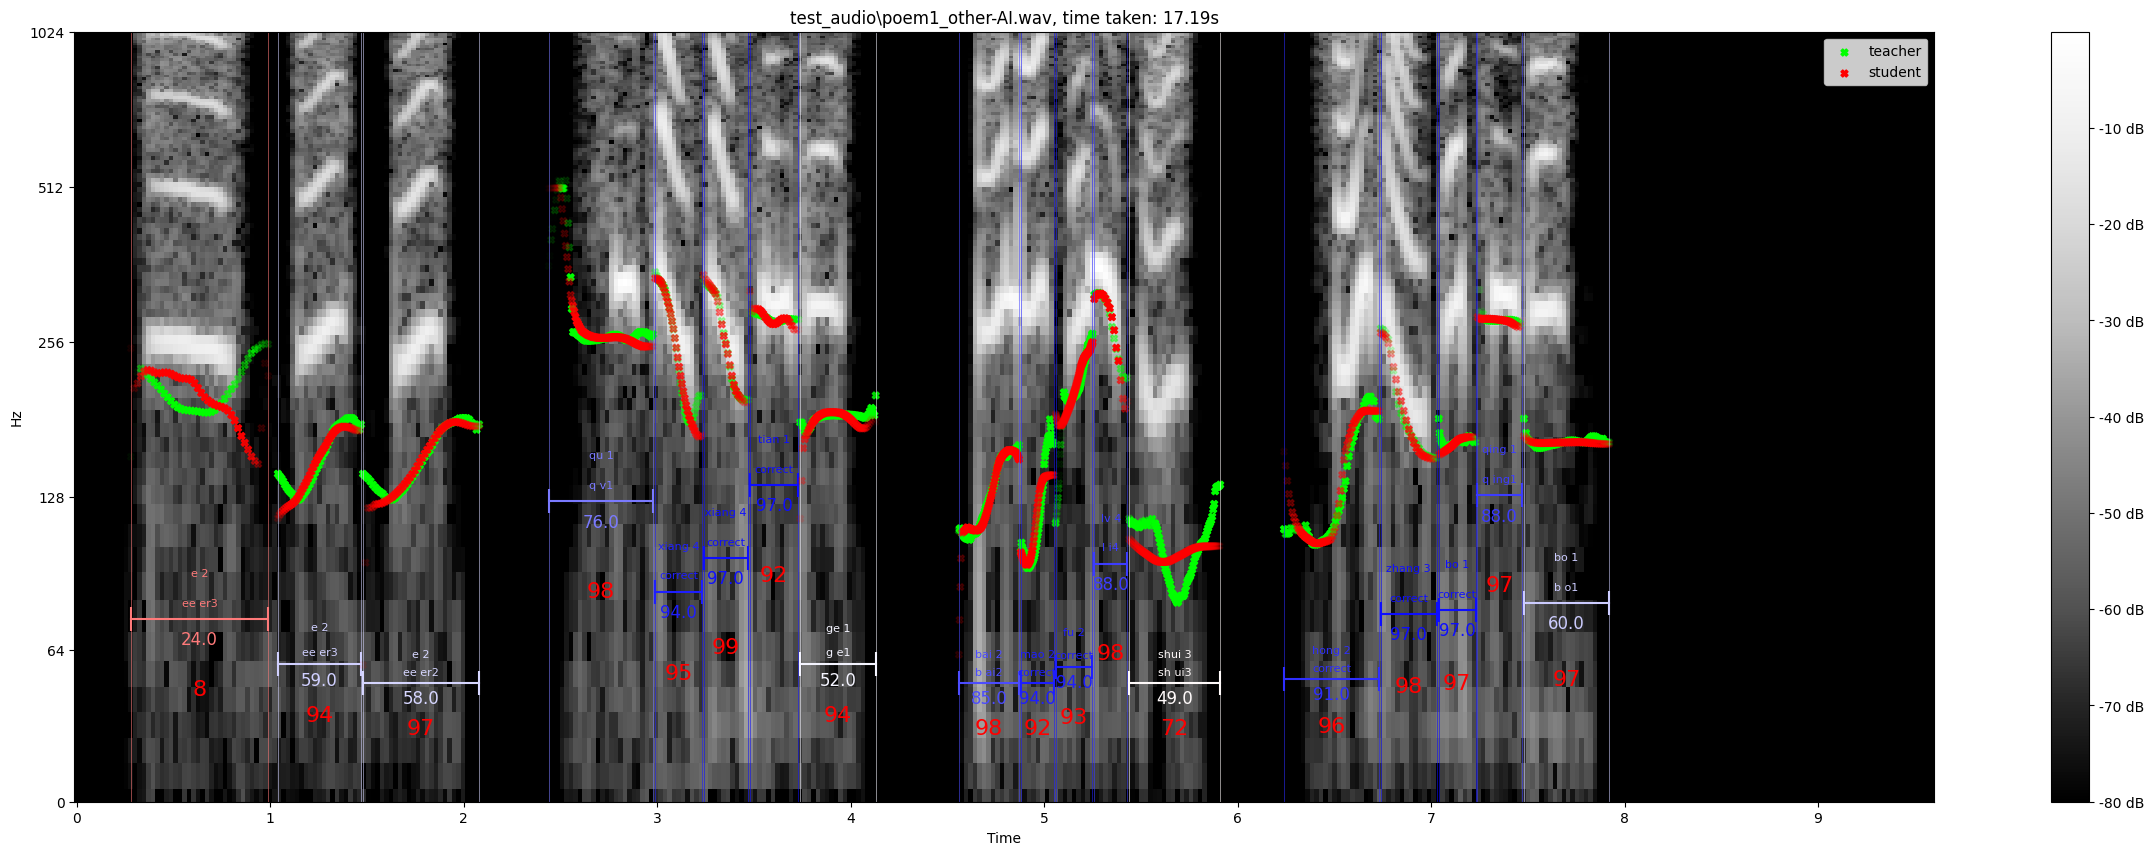

./test_audio/poem1_teacher.wav
--------------------------------
poem1_teacher.wav
time 17.895880460739136
0 - canonical: e 2 , MDD: l e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
1 - canonical: e 2 , MDD: l e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: e 2 , MDD: l e5 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
3 - canonical: qu 1 , MDD: q v1 , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
4 - canonical: xiang 4 , MDD: correct , tone recommendations: Your tone shape is correct
5 - canonical: xiang 4 , MDD: correct , tone recommendations: Your tone shape is correct
6 - canonical: tian 1 , MDD: correct , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
7 - canonical: ge 1 , MDD: k e1 , tone recommendations: Your tone shape 

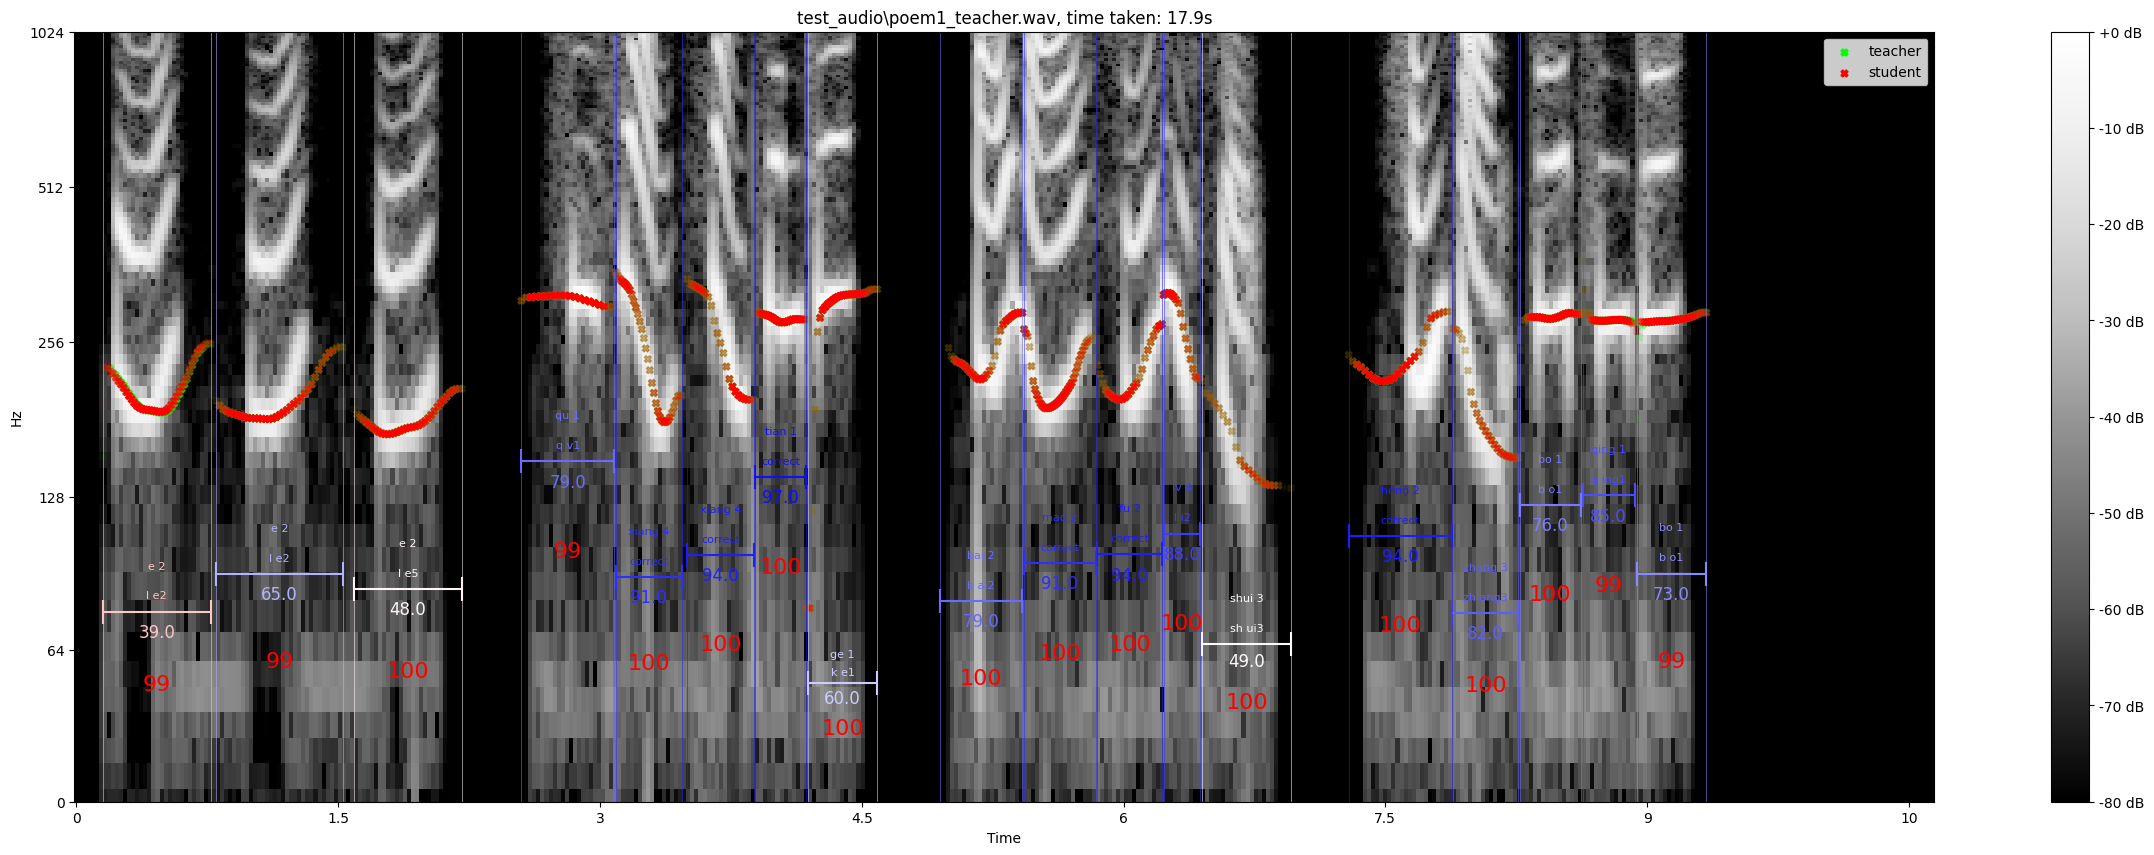

./test_audio/poem2_teacher.wav
--------------------------------
poem2_jonathan(louder).wav
time 18.591773748397827
0 - canonical: chuang 2 , MDD: ch uang2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
1 - canonical: qian 2 , MDD: q ian2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: ming 2 , MDD: correct , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
3 - canonical: yue 4 , MDD: correct , tone recommendations: Your tone shape is correct
4 - canonical: guang 1 , MDD: g uang1 , tone recommendations: Your tone shape is correct
5 - canonical: yi 2 , MDD: ii i1 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
6 - canonical: shi 4 , MDD: sh ix4 , tone recommendations: This word should have a falling tone, but you spoke it with a flat tone.
7 - canonical: di 4 , MDD: d i4 , tone recommen

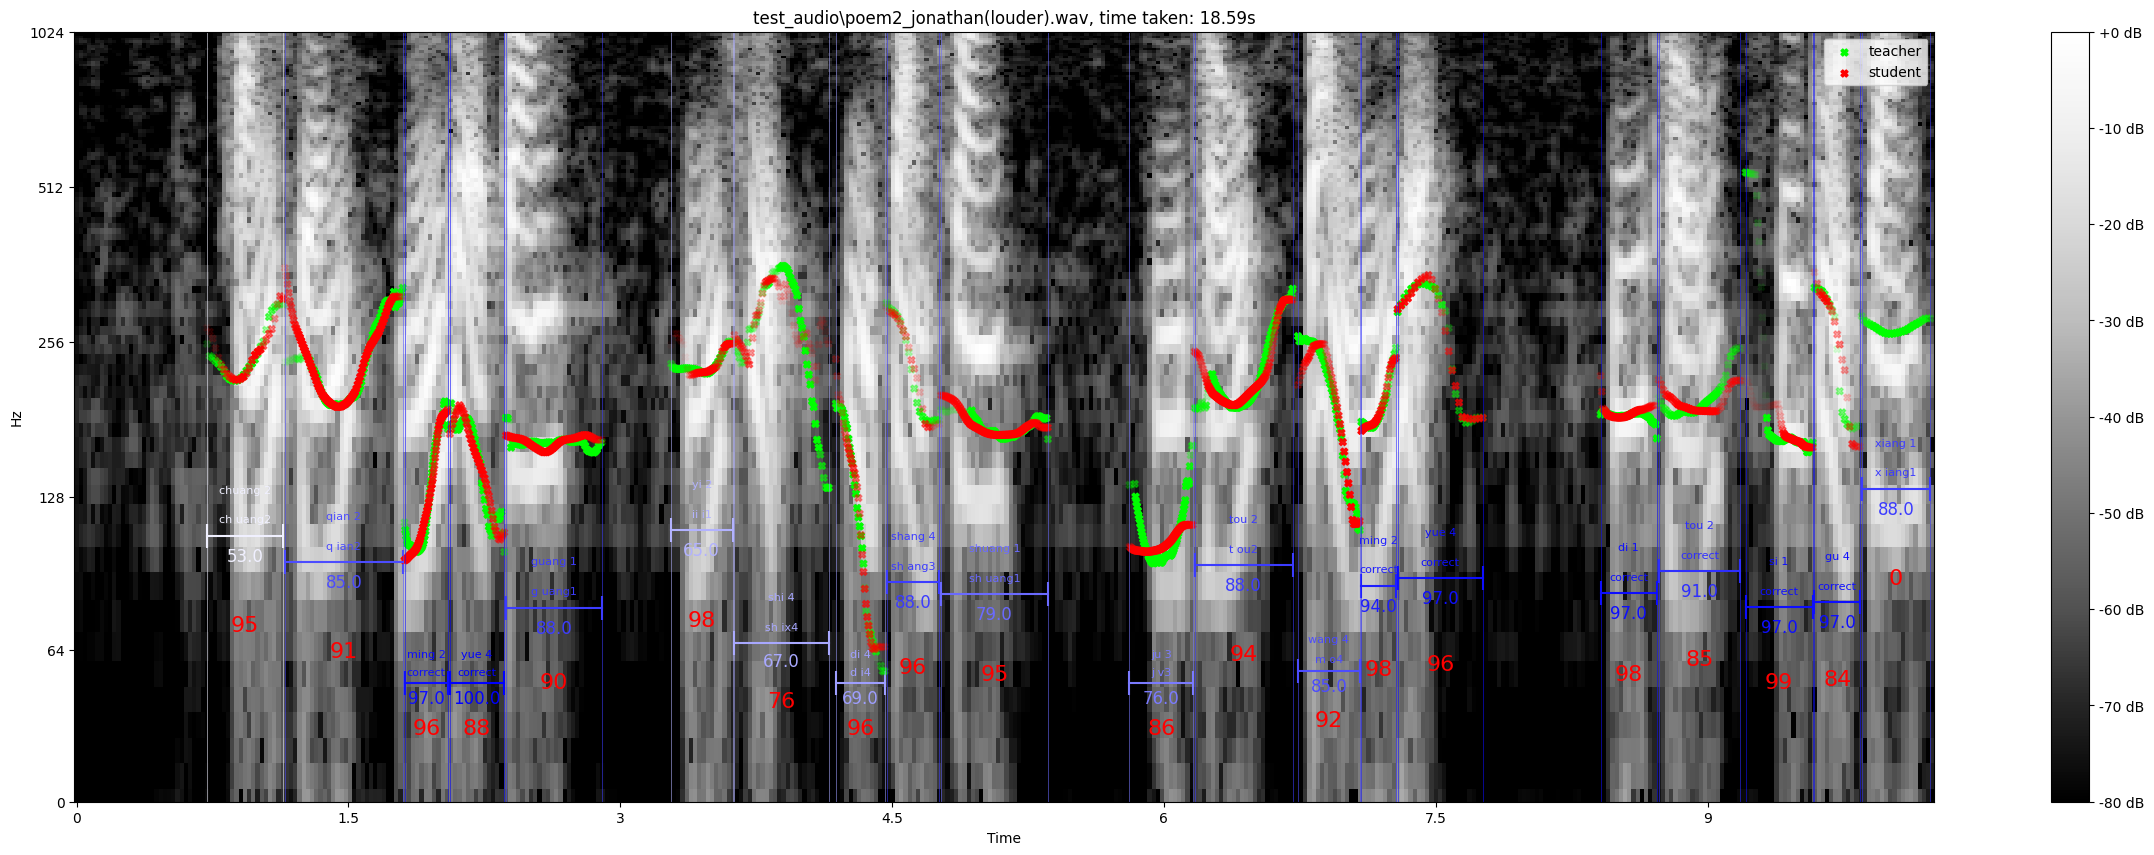

./test_audio/poem2_teacher.wav
--------------------------------
poem2_jonathan(noisy).wav
time 18.671449661254883
0 - canonical: chuang 2 , MDD: ch uang2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
1 - canonical: qian 2 , MDD: correct , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: ming 2 , MDD: correct , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
3 - canonical: yue 4 , MDD: correct , tone recommendations: This word should have a falling tone, but you spoke it with a flat tone.
4 - canonical: guang 1 , MDD: correct , tone recommendations: Your tone shape is correct
5 - canonical: yi 2 , MDD: ii i1 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
6 - canonical: shi 4 , MDD: sh ix4 , tone recommendations: This word should have a falling tone, but you spoke it with a flat tone.
7

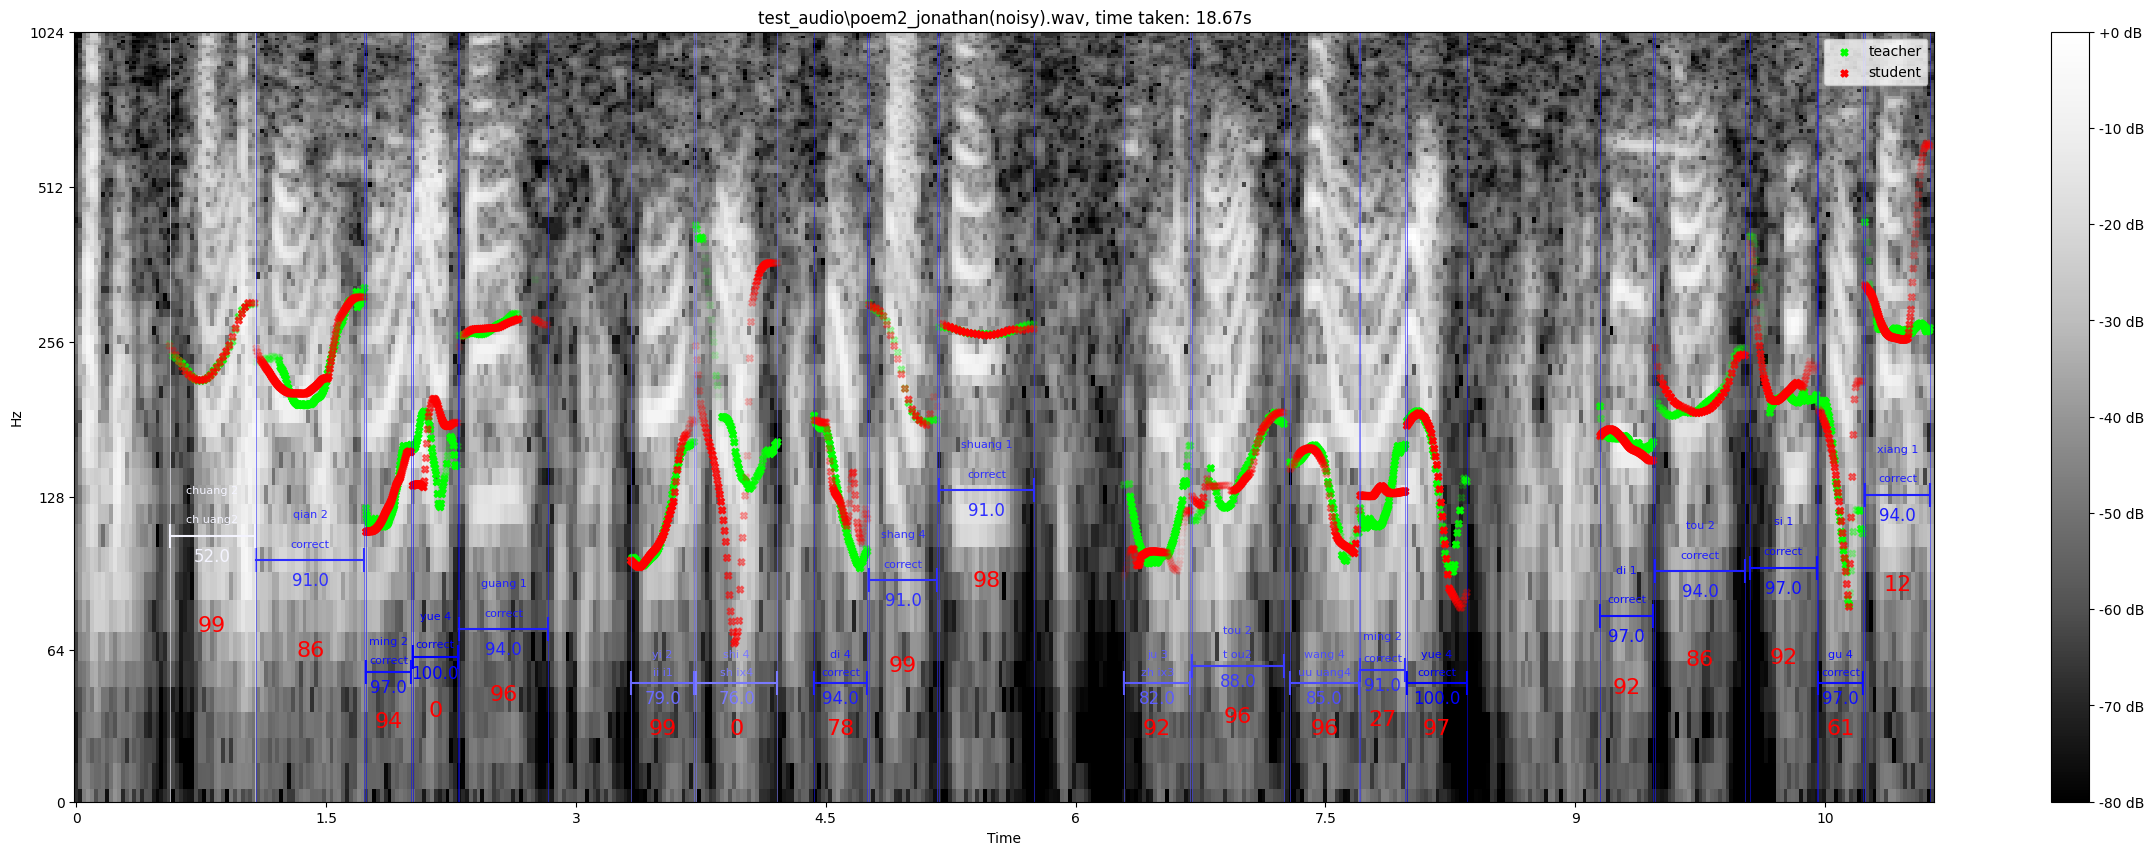

./test_audio/poem2_teacher.wav
--------------------------------
poem2_jonathan(separated).wav
time 23.778242588043213
0 - canonical: chuang 2 , MDD: ch uang2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
1 - canonical: qian 2 , MDD: q ian2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: ming 2 , MDD: m ing2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
3 - canonical: yue 4 , MDD: correct , tone recommendations: Your tone shape is correct
4 - canonical: guang 1 , MDD: g uang1 , tone recommendations: Your tone shape is correct
5 - canonical: yi 2 , MDD: ii i3 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
6 - canonical: shi 4 , MDD: sh ix4 , tone recommendations: Your tone shape is correct
7 - canonical: di 4 , MDD: d i4 , tone recommendations: Your tone shape is correct
8 - cano

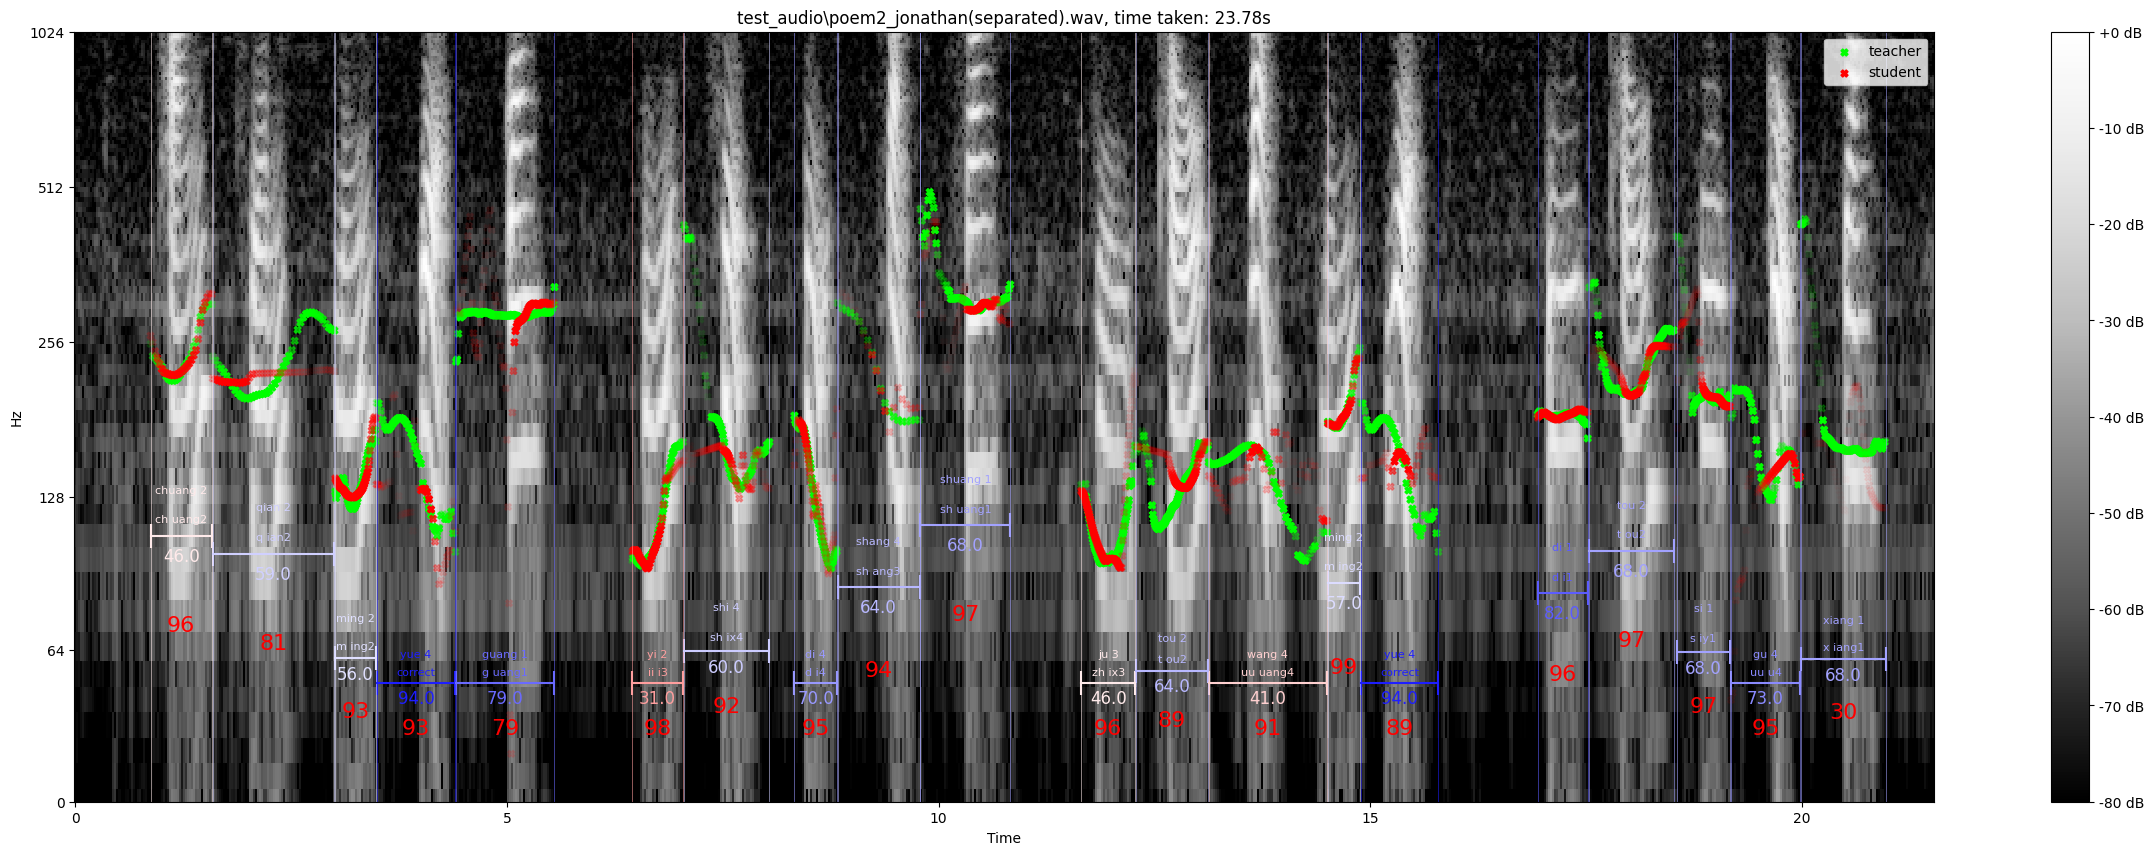

./test_audio/poem2_teacher.wav
--------------------------------
poem2_teacher.wav
time 19.433180332183838
0 - canonical: chuang 2 , MDD: ch uang2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
1 - canonical: qian 2 , MDD: q ian2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: ming 2 , MDD: m ing2 , tone recommendations: This word should have a rising tone, but you spoke it with a falling tone.
3 - canonical: yue 4 , MDD: correct , tone recommendations: Your tone shape is correct
4 - canonical: guang 1 , MDD: g uang1 , tone recommendations: Your tone shape is correct
5 - canonical: yi 2 , MDD: ii i1 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
6 - canonical: shi 4 , MDD: sh ix4 , tone recommendations: Your tone shape is correct
7 - canonical: di 4 , MDD: d i4 , tone recommendations: Your tone shape is correct
8 - canonical: sh

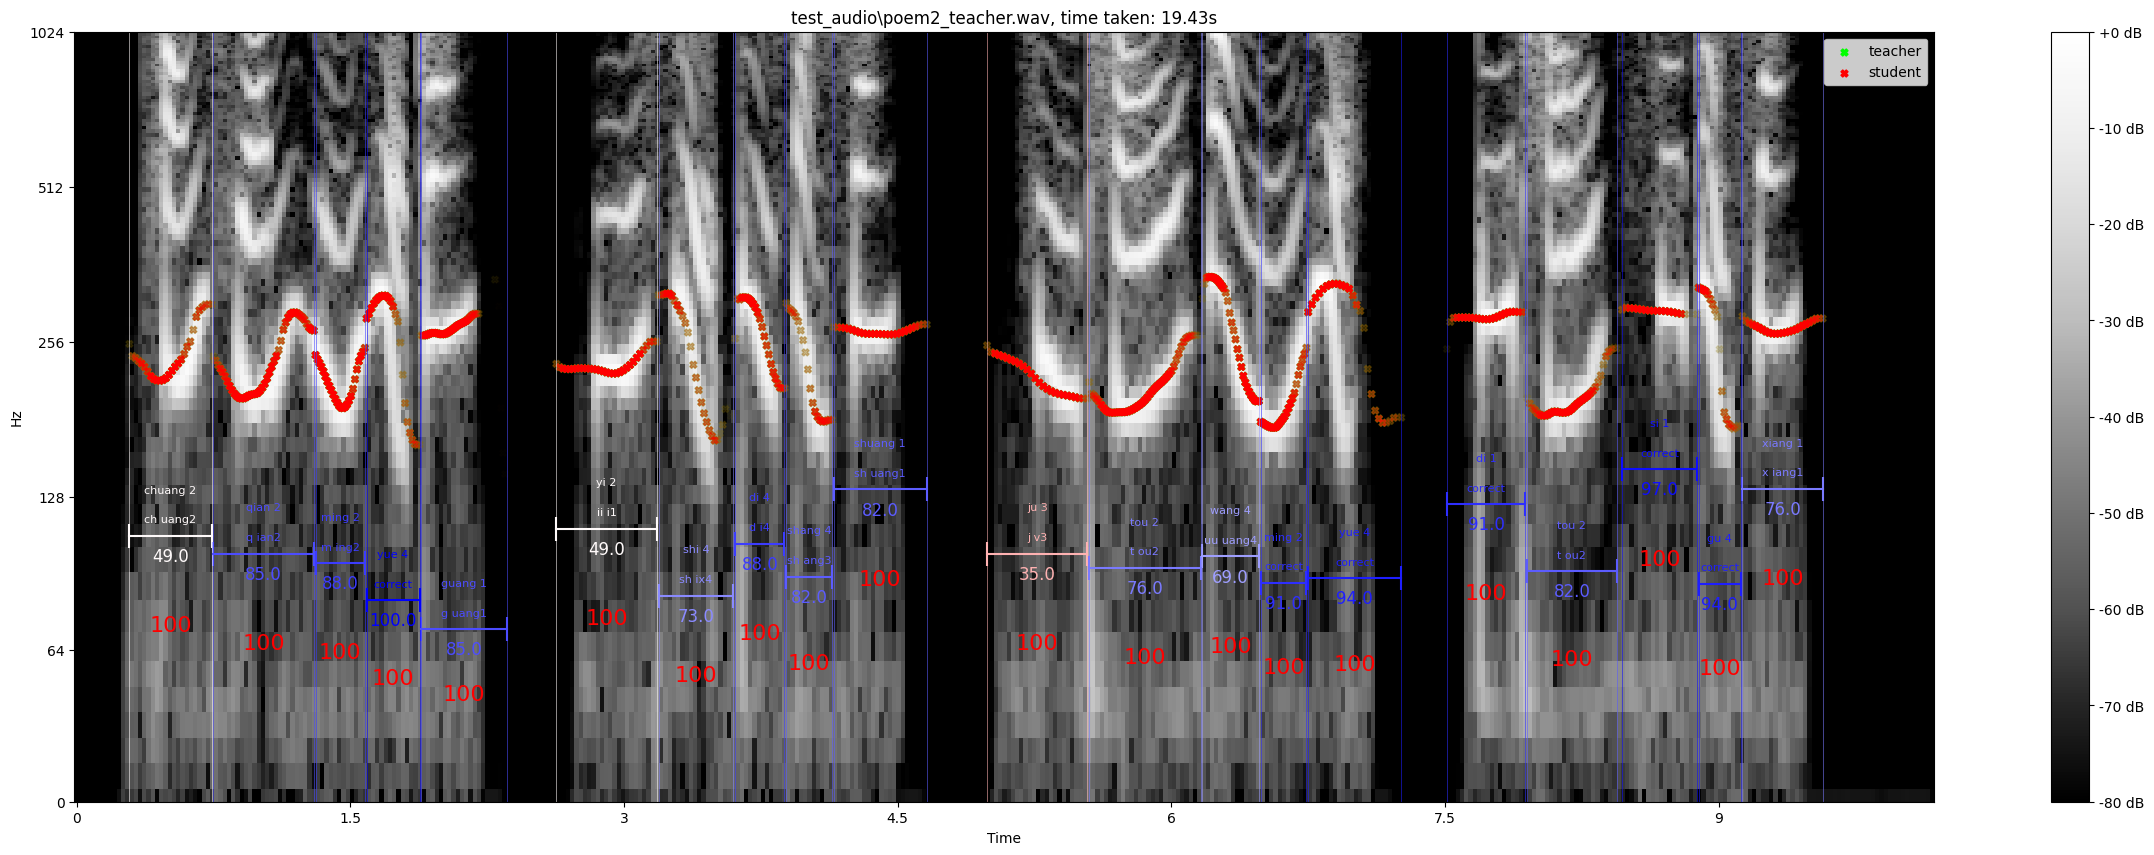

./test_audio/poem3_teacher.wav
--------------------------------
poem3_jonathan(separated).wav
time 23.33262538909912
0 - canonical: chu 2 , MDD: ch u2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
1 - canonical: he 2 , MDD: h e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: ri 4 , MDD: r iz4 , tone recommendations: Your tone shape is correct
3 - canonical: dang 1 , MDD: d ang1 , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
4 - canonical: wu 3 , MDD: uu u3 , tone recommendations: This word's tone should fall then rise, but you spoke it with a flat tone.
5 - canonical: han 4 , MDD: h an4 , tone recommendations: Your tone shape is correct
6 - canonical: di 1 , MDD: ii i1 , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
7 - canonical: he 2 , MDD: h e2 , tone recommendations: This 

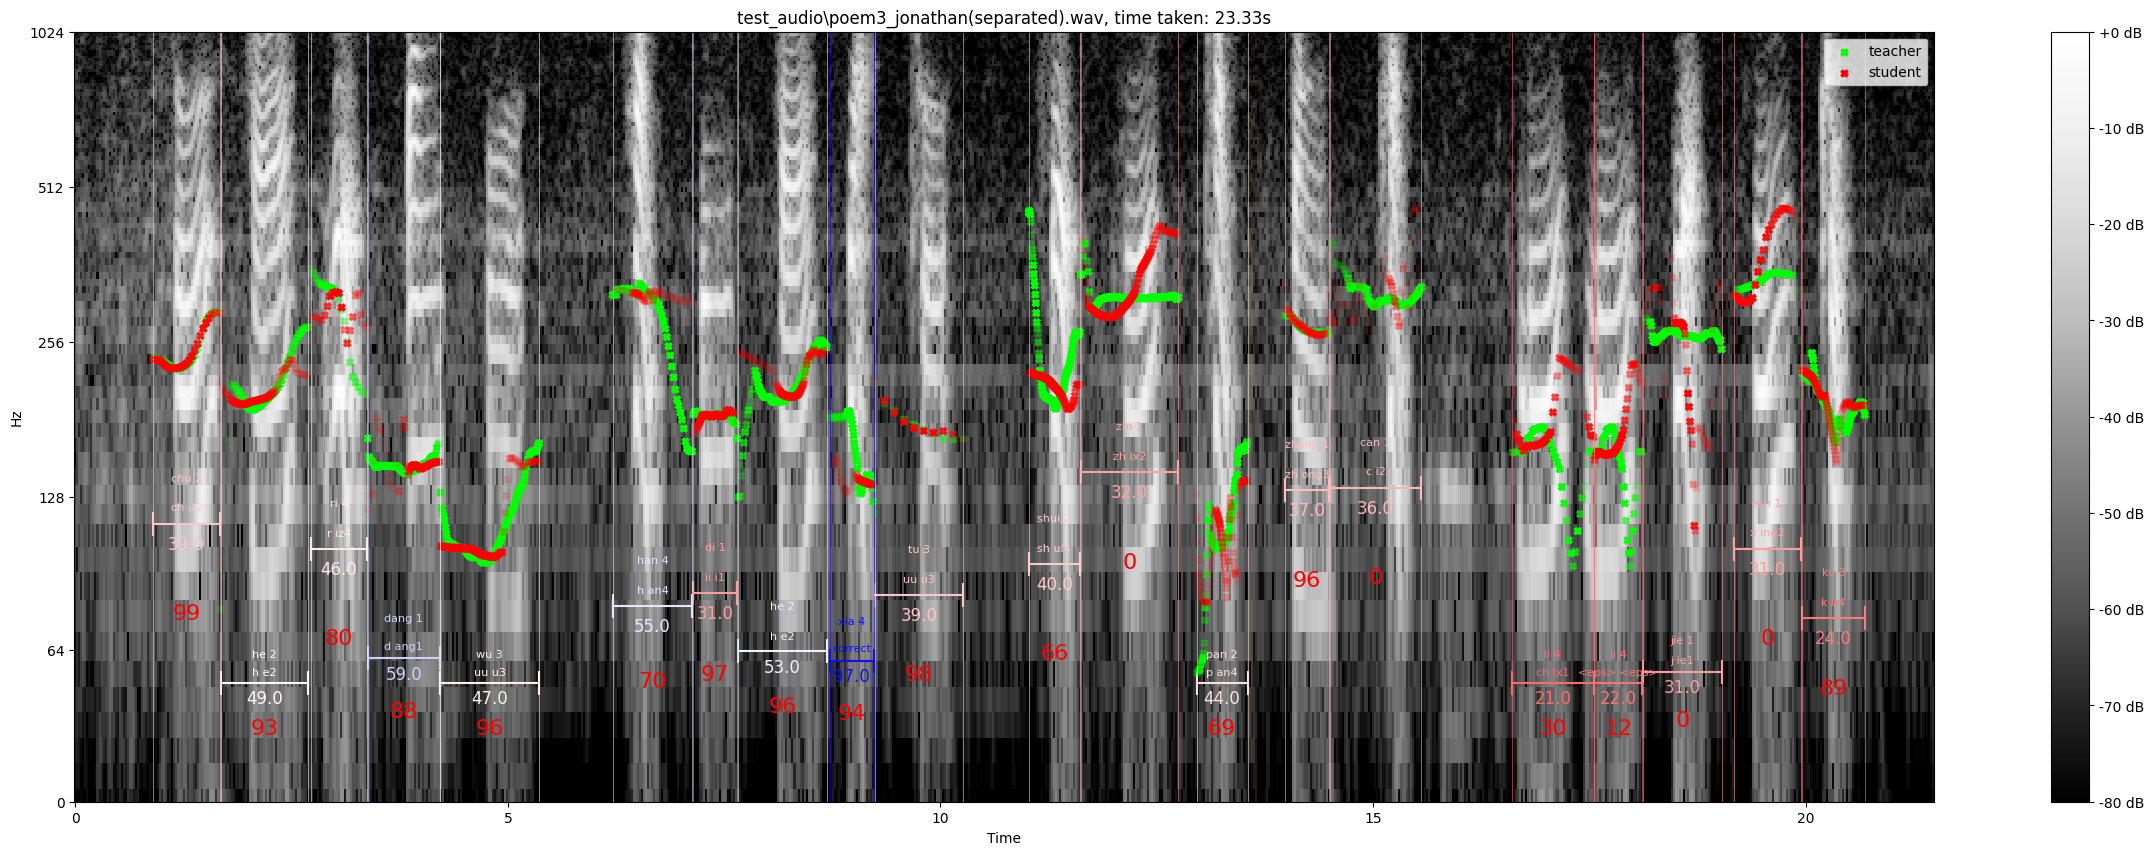

./test_audio/poem3_teacher.wav
--------------------------------
poem3_jonathan.wav
time 20.104036569595337
0 - canonical: chu 2 , MDD: ch u2 , tone recommendations: This word should have a rising tone, but you spoke it with a falling tone.
1 - canonical: he 2 , MDD: h e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: ri 4 , MDD: r ui4 , tone recommendations: Your tone shape is correct
3 - canonical: dang 1 , MDD: correct , tone recommendations: Your tone shape is correct
4 - canonical: wu 3 , MDD: uu u3 , tone recommendations: This word's tone should fall then rise, but you spoke it with a flat tone.
5 - canonical: han 4 , MDD: correct , tone recommendations: Your tone shape is correct
6 - canonical: di 1 , MDD: d i1 , tone recommendations: Your tone shape is correct
7 - canonical: he 2 , MDD: h e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
8 - canonical: xia 4 , MDD: co

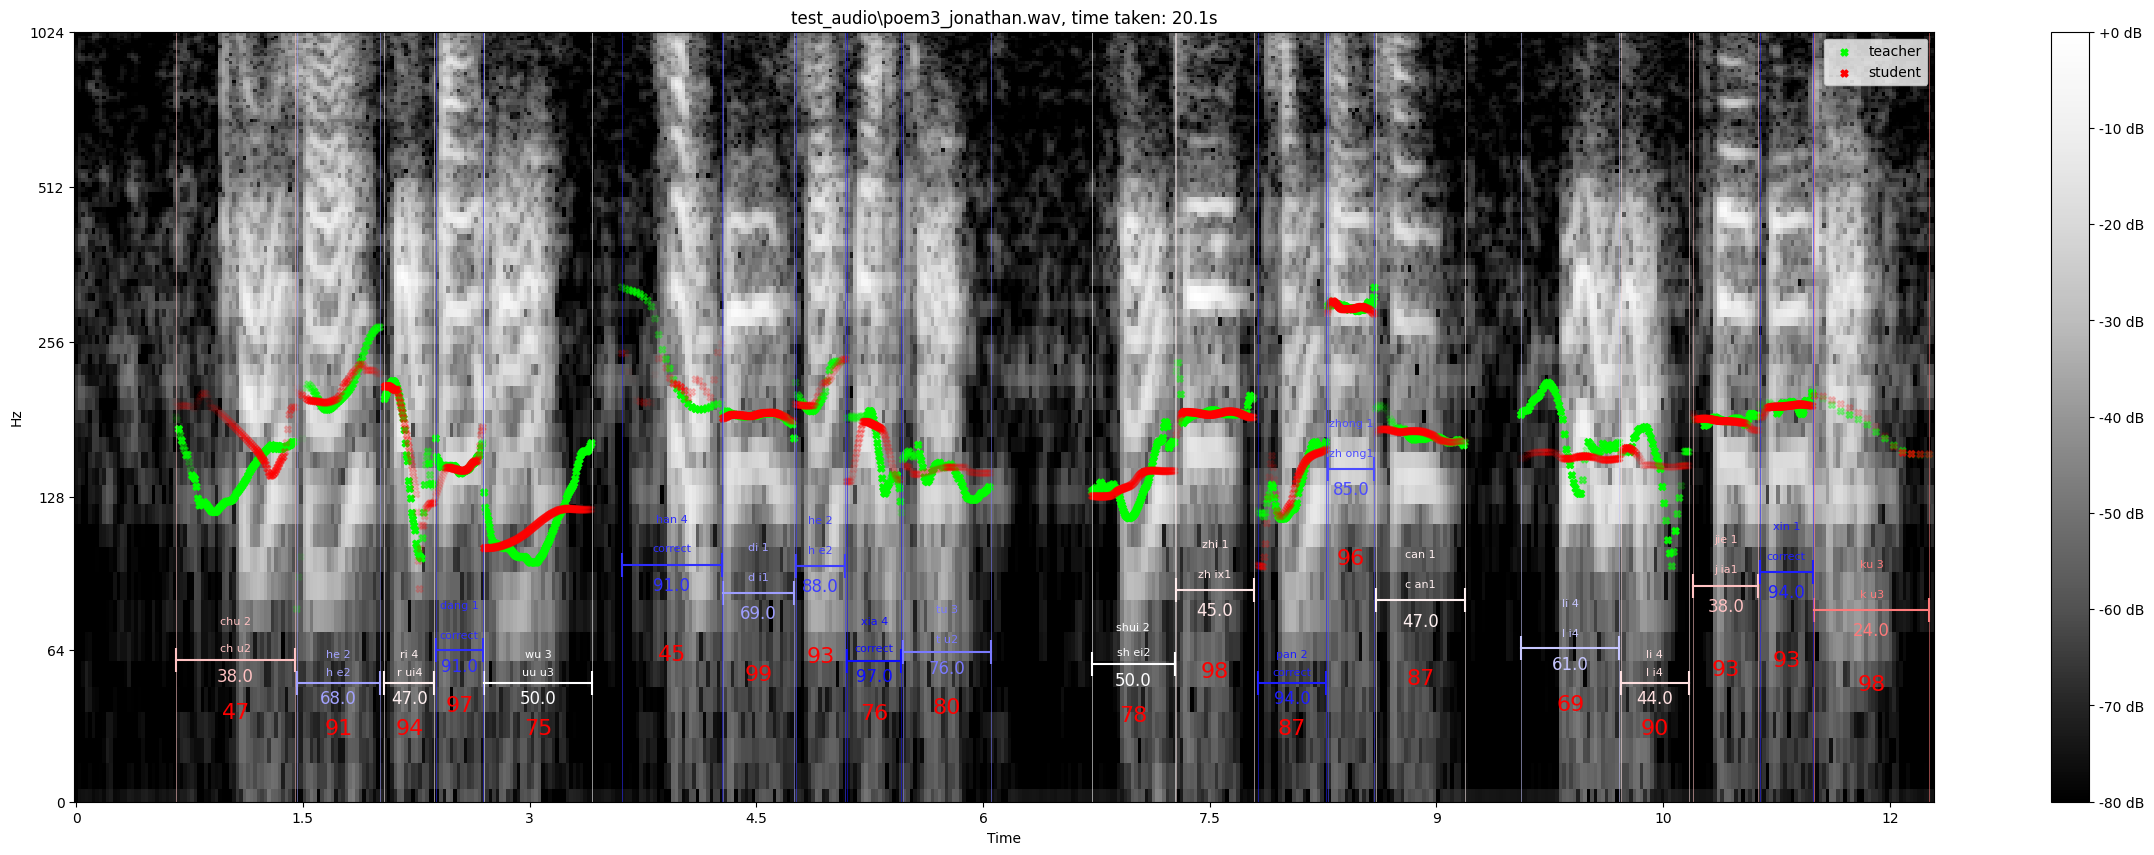

./test_audio/poem3_teacher.wav
--------------------------------
poem3_jonathan2.wav
time 19.215859174728394
0 - canonical: chu 2 , MDD: ch u2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
1 - canonical: he 2 , MDD: h e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: ri 4 , MDD: r iz4 , tone recommendations: Your tone shape is correct
3 - canonical: dang 1 , MDD: correct , tone recommendations: Your tone shape is correct
4 - canonical: wu 3 , MDD: uu u2 , tone recommendations: This word's tone should fall then rise, but you spoke it with a flat tone.
5 - canonical: han 4 , MDD: correct , tone recommendations: This word should have a falling tone, but you spoke it with a flat tone.
6 - canonical: di 1 , MDD: d i1 , tone recommendations: This word should have a flat tone, but you spoke it with a falling tone.
7 - canonical: he 2 , MDD: h e2 , tone recommendations: This word sh

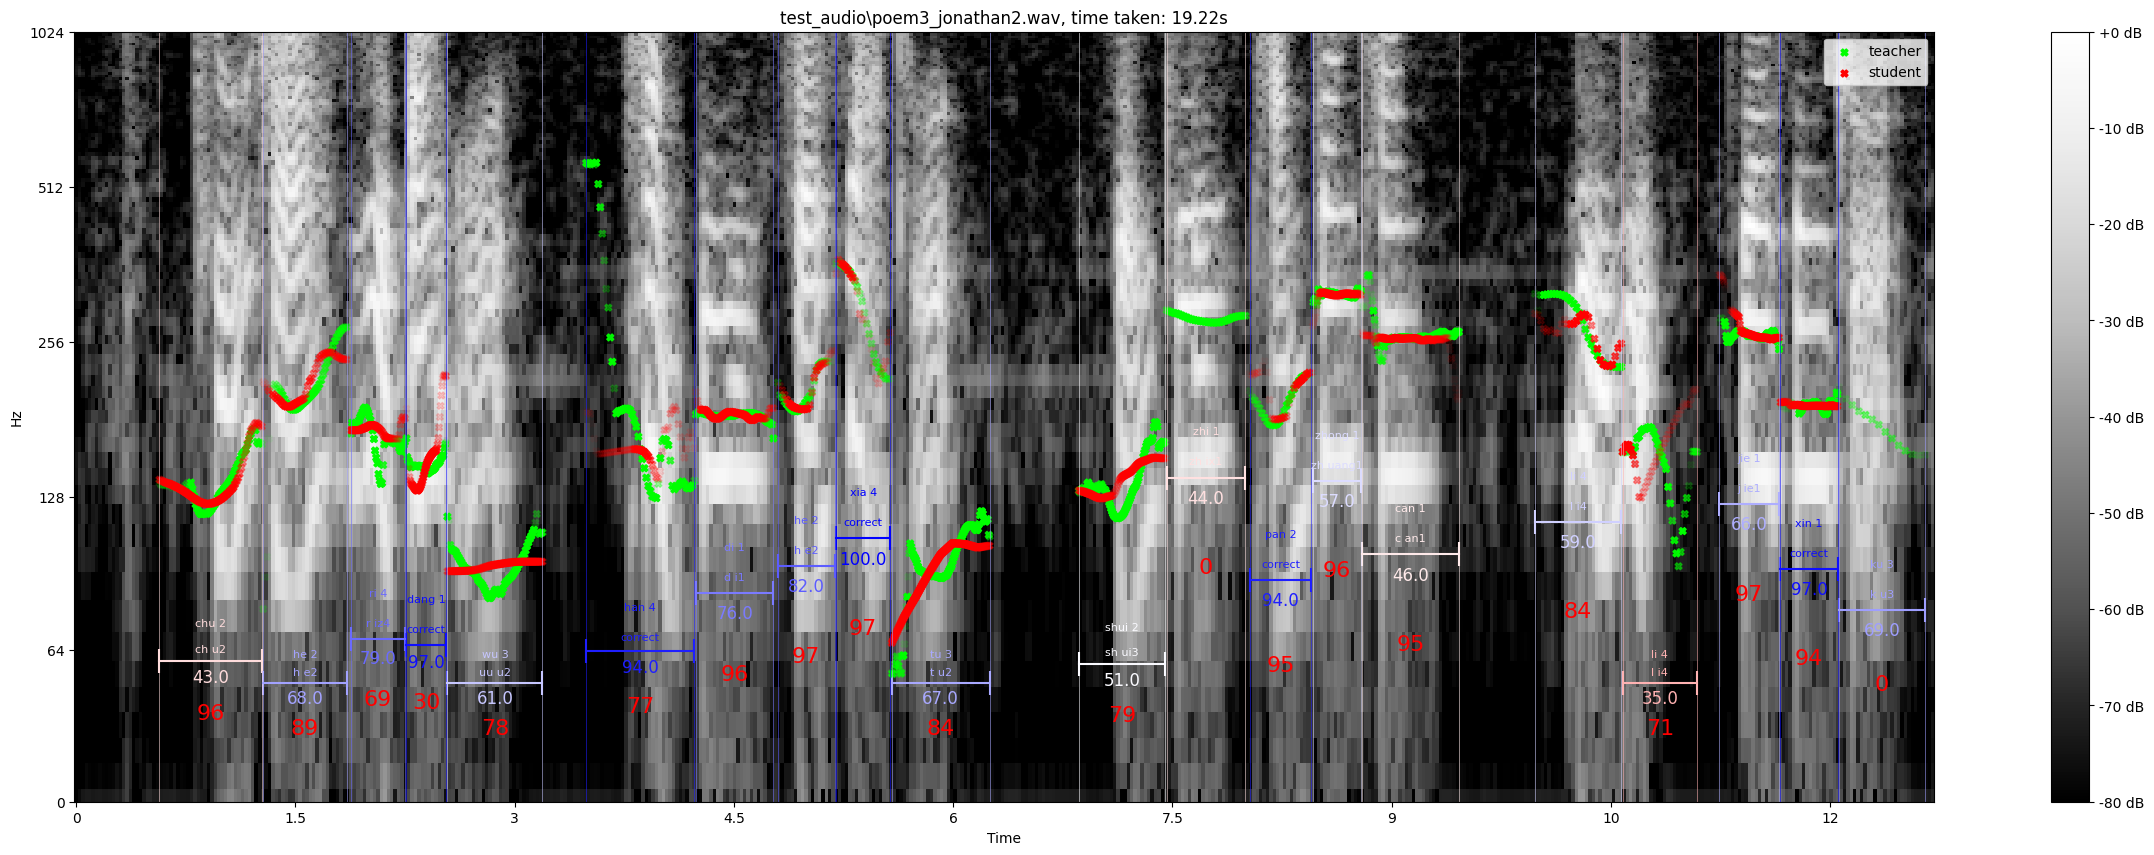

./test_audio/poem3_teacher.wav
--------------------------------
poem3_teacher.wav
time 18.620656490325928
0 - canonical: chu 2 , MDD: ch u2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
1 - canonical: he 2 , MDD: h e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
2 - canonical: ri 4 , MDD: r iz4 , tone recommendations: Your tone shape is correct
3 - canonical: dang 1 , MDD: correct , tone recommendations: Your tone shape is correct
4 - canonical: wu 3 , MDD: uu u4 , tone recommendations: Your tone shape is correct
5 - canonical: han 4 , MDD: correct , tone recommendations: Your tone shape is correct
6 - canonical: di 1 , MDD: correct , tone recommendations: Your tone shape is correct
7 - canonical: he 2 , MDD: h e2 , tone recommendations: This word should have a rising tone, but you spoke it with a flat tone.
8 - canonical: xia 4 , MDD: correct , tone recommendations: Your tone shape is 

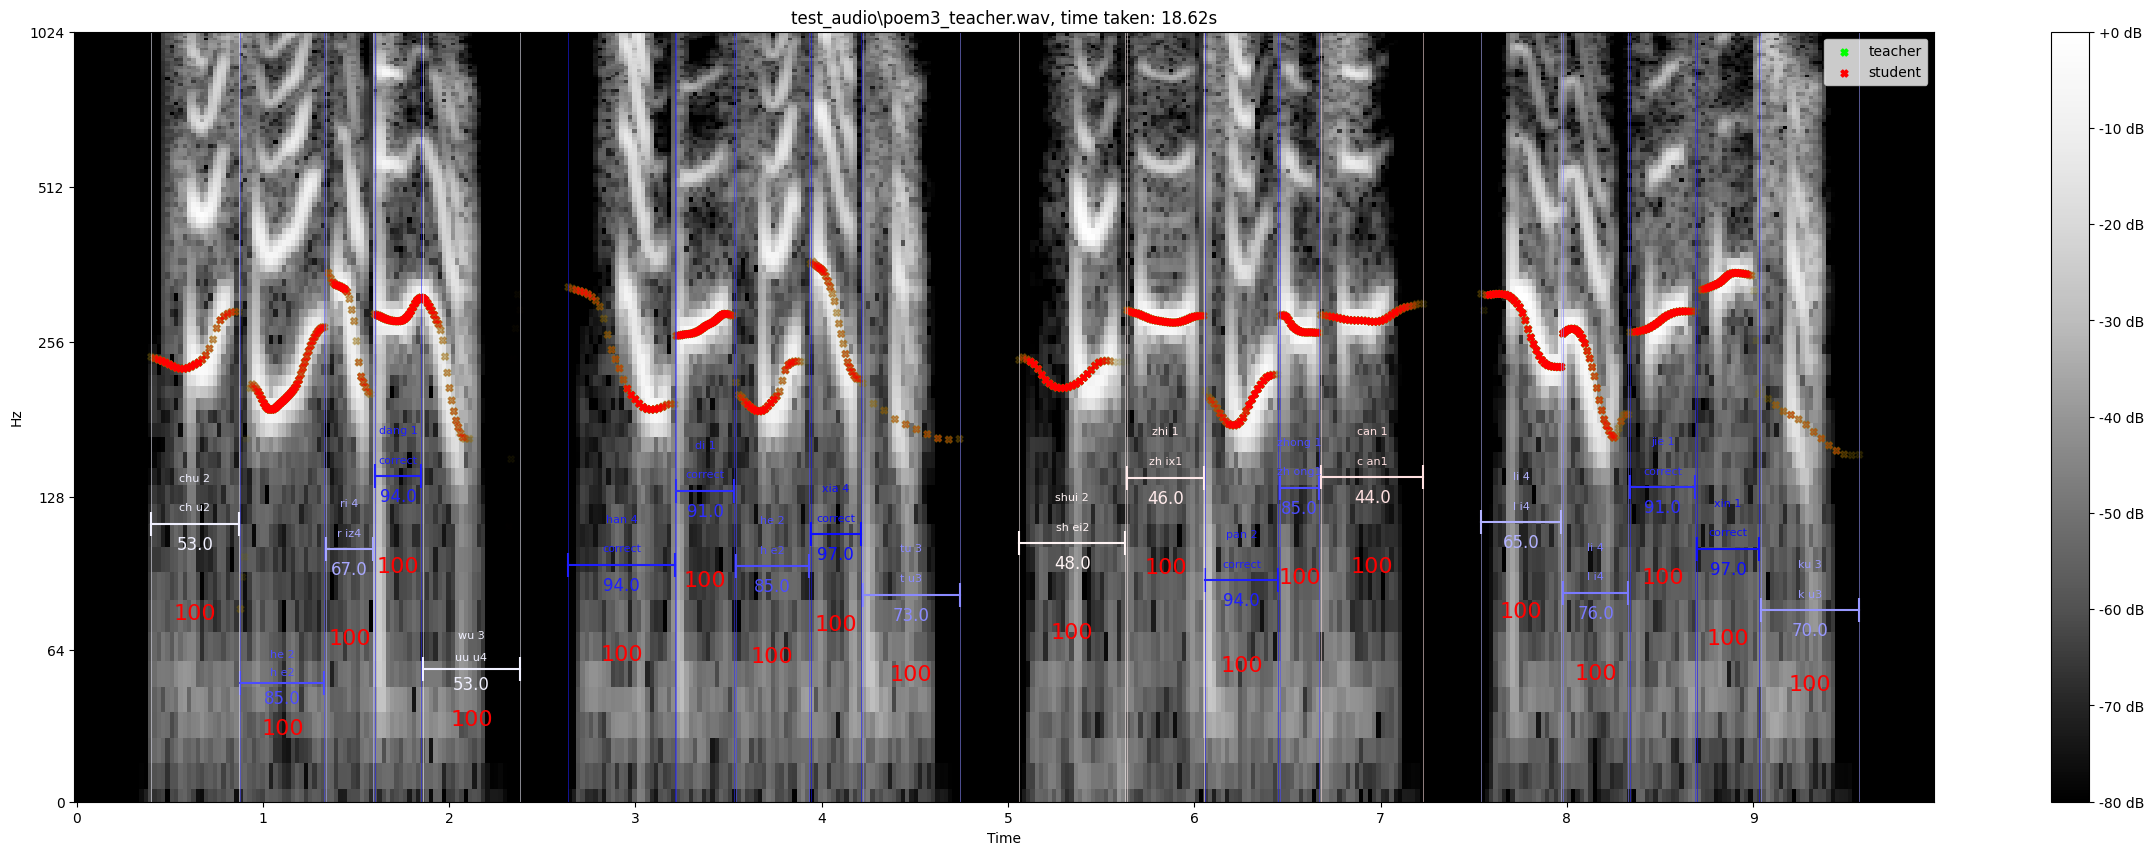

In [4]:
transcription_dict = {'poem1': '鹅,鹅,鹅。曲项向天歌。白毛浮绿水，红掌拨清波。',
                      'poem2': '床前明月光，疑是地上霜。举头望明月，低头思故乡。',
                      'poem3': '锄禾日当午，汗滴禾下土。谁知盘中餐，粒粒皆辛苦。'}


returns = {}
for wav_student_path in list(glob.glob('./test_audio/*')):
    poem_ID = wav_student_path.split('/')[-1].split('\\')[-1].split("_")[0]
    transcription = transcription_dict[poem_ID]
    wav_teacher_path = './test_audio/'+poem_ID+'_teacher.wav'
    print(wav_teacher_path)
    print('--------------------------------')
    print(wav_student_path.split('/')[-1].split('\\')[-1])
    metadata = 'kids,testing, '+poem_ID.replace('poem','poem_')+', line_0, temp_username,against_teacher,none'
    start_time = time.time()
    response_azure = get_response(wav_student_path, wav_teacher_path, transcription, metadata)
    time_taken = time.time() - start_time
    print('time', time_taken)
    visualise_results(wav_student_path, response_azure.text, time_taken, display = True)
    